In [2]:
import pandas as pd
import json
import ast
import math
from scipy.optimize import minimize_scalar
import numpy as np

# importing custom model and gridworld code
import sys
sys.path.append('../dual_model/src')
from grid import Grid
from agent import Agent

In [3]:
TEST_GRIDS = {}
with open('../web_experiments/insight_experiment/test_data.json') as json_file:
    grids = json.load(json_file)
    for gridnum, grid in grids.items():
        python_grid = {key: tuple(value) for key, value in grid.items() if key!="best_reward"}
        python_grid['best_reward'] = grid['best_reward']
        python_grid['num1'] = 1
        python_grid['num2'] = 2
        TEST_GRIDS[int(gridnum)] = python_grid

In [4]:
def transform_pos(pos):
    return tuple([4-pos[1],pos[0]])

def preprocess(data):
    preprocessed = pd.read_csv(data)
    preprocessed = preprocessed[(preprocessed['type']=='test') & (preprocessed['step']<6)]
    preprocessed = preprocessed[~preprocessed.groupby(['userid', 'trialnum'])['action'].transform(lambda x: x.isnull().any())]
    preprocessed['state'] = preprocessed['state'].apply(ast.literal_eval)
    preprocessed['transformed_state'] = preprocessed.apply(lambda row: (
        transform_pos(row['state']['agent']),
        transform_pos(row['state']['train']),
        transform_pos(row['state']['cargo1']),
        transform_pos(row['state']['cargo2']),
        row['step']
    ), axis=1)
    preprocessed['action'] = preprocessed['action'].map({'x':0, '^':1, '>':2, 'v':3, '<':4} )
    return preprocessed

insight_data = preprocess('data/insight_data_after_exclusions.csv')
time_pressure_data = preprocess('data/time_pressure_data_after_exclusions.csv') 

In [30]:
def softmax(x, temperature):
        x = np.array(x) / temperature
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

def neg_log_likelihood(beta, data, model):
    nll = -np.sum(data.apply(lambda x: math.log(softmax(x[model+'_Q'],beta)[x.action]), axis=1))
    return nll

def calculate_NLL(model, iters, data):
    np.random.seed()
    agent=Agent()
    Q_dict = {}
    for gridnum, grid in TEST_GRIDS.items():
        grid = Grid(init_pos=grid)
        if model == 'MC':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=False)
        if model == 'dual':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=True, compute_full_Q_dict=True)
        if model == 'NN':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=0, nn_init=True, compute_full_Q_dict=True)
    data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)
    beta = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, model),bounds=(0.01, 10), method='bounded').x
    return neg_log_likelihood(beta, data, model)

def calculate_BIC(nll, data, free_params=1):
    return free_params * math.log(len(data)) + 2 * nll

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

def calculate_NLL(x, model="MC", data=insight_data):
    beta = x[0] 
    iters = x[1]
    agent=Agent()
    Q_dict = {}
    for gridnum, grid in TEST_GRIDS.items():
        grid = Grid(init_pos=grid)
        if model == 'MC':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=False)
        if model == 'dual':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=True, compute_full_Q_dict=True)
    data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)
    nll = neg_log_likelihood(beta, data, model)
    print(beta, iters, nll)
    return nll

In [44]:
from skopt import gp_minimize

res = gp_minimize(calculate_NLL,                  # the function to minimize
                  [(0.1, 1), (50,10000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   

Iteration No: 1 started. Evaluating function at random point.
0.5478972998253845 8187 82274.93907924046
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 321.0571
Function value obtained: 82274.9391
Current minimum: 82274.9391
Iteration No: 2 started. Evaluating function at random point.
0.6509007052095438 7725 85909.82261053467
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 294.6545
Function value obtained: 85909.8226
Current minimum: 82274.9391
Iteration No: 3 started. Evaluating function at random point.
0.8746027942399187 1549 90900.71776973436
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 65.5634
Function value obtained: 90900.7178
Current minimum: 82274.9391
Iteration No: 4 started. Evaluating function at random point.
0.2786668831235539 8161 74034.81674515492
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 320.1900
Function value obtained: 74034.8167
Current minimum: 74034.8167
Iteration No: 5 start

KeyboardInterrupt: 

In [42]:
res

          fun: 83832.10536707965
            x: [0.24509984534334822, 500]
    func_vals: [ 8.700e+04  8.871e+04 ...  9.708e+04  8.593e+04]
      x_iters: [[0.5478972998253845, 418], [0.6509007052095438, 397], [0.8746027942399187, 118], [0.2786668831235539, 417], [0.24293381786599288, 102], [0.111616778007862, 269], [0.3979138854252683, 411], [0.18842674199548784, 75], [0.49839638406330067, 60], [0.3616556979296883, 161], [0.1, 443], [0.2307789632204187, 381], [0.3267433333200739, 500], [0.3156174195250607, 366], [0.4703921808085477, 500], [0.1, 487], [0.7450073677462864, 500], [0.1, 415], [1.0, 500], [0.5931454200755015, 500], [0.37308476096231113, 500], [0.35764315058299545, 500], [0.6929929631840949, 50], [0.4292231355702868, 500], [0.3639769689460698, 447], [0.5665011312549232, 500], [0.6508422213164894, 459], [1.0, 50], [0.36256638220402615, 500], [0.3648469667654368, 500], [0.8426638389678703, 500], [0.4082421456164671, 500], [0.3577348169695209, 500], [0.45955315154117515, 500],

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

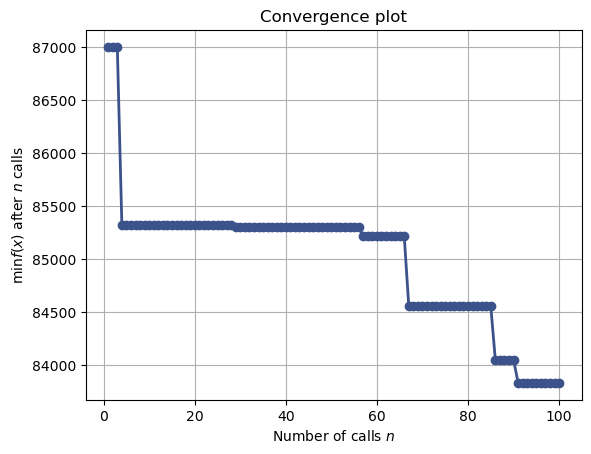

In [43]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [37]:
from multiprocess import Pool
ITERS = [100, 200, 300]
repeats = 4

def calculate_average_NLL(model, iters, data):
    nll = []
    for iter in iters:
        with Pool() as pool:
            nll_runs = pool.map(lambda _: calculate_NLL(model, iter, insight_data), range(repeats))
        print(np.mean(nll_runs), nll_runs)
        nll += [np.mean(nll_runs)]
    return nll

mc_nll = calculate_average_NLL("MC", ITERS, insight_data) 
print(mc_nll)
dual_nll = calculate_average_NLL("dual", ITERS, insight_data)
print(dual_nll)
nn_nll = calculate_NLL('NN', 0, insight_data)
print(nn_nll)

95132.98736475845 [95132.98736475845, 95132.98736475845, 95132.98736475845, 95132.98736475845]
94327.22812021631 [94327.22812021631, 94327.22812021631, 94327.22812021631, 94327.22812021631]
90779.63523475744 [90779.63523475744, 90779.63523475744, 90779.63523475744, 90779.63523475744]
[95132.98736475845, 94327.22812021631, 90779.63523475744]
neural net loadedneural net loadedneural net loaded


neural net loaded
76869.19371648801 [76869.19371648801, 76869.19371648801, 76869.19371648801, 76869.19371648801]
neural net loadedneural net loadedneural net loadedneural net loaded



75473.80156288529 [75473.80156288529, 75473.80156288529, 75473.80156288529, 75473.80156288529]
neural net loadedneural net loadedneural net loadedneural net loaded



75234.08111056856 [75234.08111056856, 75234.08111056856, 75234.08111056856, 75234.08111056856]
[76869.19371648801, 75473.80156288529, 75234.08111056856]
neural net loaded
78797.89812364028


In [38]:
nll_mc1000 = calculate_NLL('MC', 1000, insight_data)

In [41]:
time_delay = time_pressure_data[time_pressure_data['timed'] == 0]
time_pressure = time_pressure_data[time_pressure_data['timed'] == 1]
nll_dualdelay = calculate_BIC('dual', 100, time_delay)
nll_nndelay = calculate_BIC('NN', 0, time_delay)
nll_dualpressure = calculate_BIC('dual', 100, time_pressure)
nll_nnpressure = calculate_BIC('NN', 0, time_pressure)

neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


In [42]:
print("model fits under time delay: ")
print("NN: ", nll_nndelay, ", dual: ", nll_dualdelay)
print("model fits under time pressure: ")
print("NN: ", nll_nnpressure, ", dual: ", nll_dualpressure)

model fits under time delay: 
NN:  47535.9265049618 , dual:  45155.72692610109
model fits under time pressure: 
NN:  37339.21171737829 , dual:  37334.46276200564


In [158]:
data = insight_data #insight_data[(insight_data['gridnum']<=208) & (insight_data['gridnum']>=101)]
mc = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'MC'),bounds=(0.01, 10), method='bounded')
nn = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'NN'),bounds=(0.01, 10), method='bounded')
dual = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'dual'),bounds=(0.01, 10), method='bounded')

mc_nll = neg_log_likelihood(mc.x, data, 'MC')
nn_nll = neg_log_likelihood(nn.x, data, 'NN')
dual_nll = neg_log_likelihood(dual.x, data, 'dual')

print("MC beta: ", mc.x, "MC NLL: ", mc_nll)
print("NN beta: ", nn.x, "NN NLL: ", nn_nll)
print("Dual beta: ", dual.x, "Dual NLL: ", dual_nll)

MC beta:  0.895068768407847 MC NLL:  99007.51670779652
NN beta:  0.29526529859323564 NN NLL:  78797.89812364028
Dual beta:  0.21289758604386932 Dual NLL:  77794.25258437687


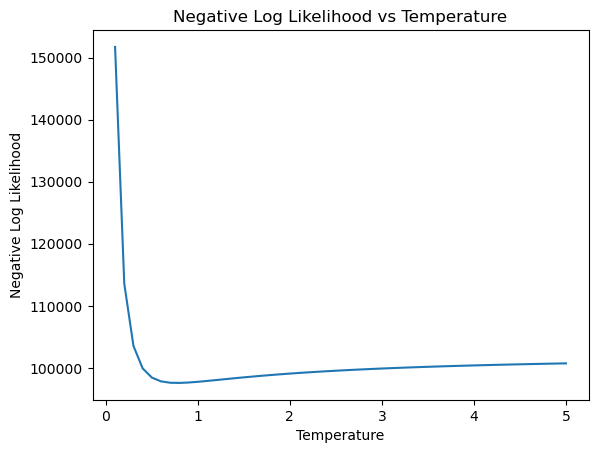

In [142]:
import matplotlib.pyplot as plt

temperatures = np.linspace(0.1, 5, 50)
nll_values = [neg_log_likelihood(temp, data, 'MC') for temp in temperatures]

plt.plot(temperatures, nll_values)
plt.xlabel('Temperature')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood vs Temperature')
plt.show()

MC beta:  0.7707871244153109 MC NLL:  97558.15379185592
NN beta:  0.29526529859323564 NN NLL:  78797.89812364028
Dual beta:  0.18734479803382798 Dual NLL:  75546.44079410128
